## SVM 支持向量机

第一个部分旨在使用可视化的方式让同学们理解SVM的工作原理, SVM分割线, SVM的支持向量. 并且使用实例证明SVM的分割线只由支持向量唯一缺点, 与线性回归/逻辑回归不一样, SVM对异常数据具有较强的**鲁棒性**.

第二个部分展示了如何使用支持向量机实现人脸的分类识别. 对输入的人脸图像, 使用 **PCA(主成分分析)** 将图像(看作一维向量)进行了降维处理, 然后将降维后的向量作为支持向量机的输入. PCA降维的目的可以看作是特征提取, 将图像里面真正对分类有决定性影响的数据提取出来.


## 一、理解SVM

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns; sns.set()

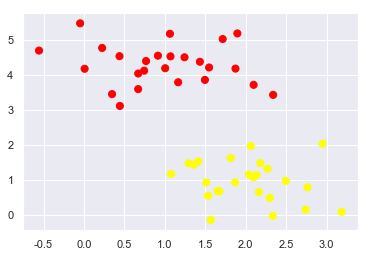

In [34]:
# make_blobs函数是为聚类产生数据集产生一个数据集和相应的标签
#     n_samples:表示数据样本点个数,默认值100
#     n_features:表示数据的维度，默认值是2
#     centers:产生数据的中心点，默认值3------------> centers等于几，所产生的类别就有几类。
#     cluster_std：数据集的标准差，浮点数或者浮点数序列，默认值1.0
#     center_box：中心确定之后的数据边界，默认值(-10.0, 10.0)
#     shuffle ：洗乱，默认值是True
#     random_state:官网解释是随机生成器的种子

from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)  # 生成了一个具有50个样本点，分为两类的带有标签y的二维数据集。

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')  # 具体哪些点对应哪类，scatter不知道，他只负责将这些点画出来，
                                                         # 画出来后你就可以通过观察发现有多少类。

In [35]:
y[:]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0])

In [36]:
X.shape

(50, 2)

## 可以有多种分类方法

In [5]:
X[:, 1]

array([ 1.5303347 ,  1.6311307 ,  4.37679234,  4.18069237,  1.0791468 ,
        0.15676817,  0.08900822,  1.96918596,  1.15466278,  5.47425256,
        5.02521524,  4.77028154,  4.53068484,  0.55035386,  3.85848832,
        3.79132988,  4.12240568,  0.48677761,  3.11530945,  4.55014643,
        0.68001896,  1.32160756,  0.9288309 ,  0.68193176,  0.97505341,
        3.43116792,  4.04094275,  4.69595848,  0.6565951 ,  3.7174206 ,
        1.48364708,  4.53592883,  4.50399192,  4.17614316,  5.18540259,
        0.93136287,  1.13885728,  5.17635143, -0.02408255,  3.59540802,
        1.17533301,  4.212973  , -0.1381059 ,  1.43815955,  4.19147702,
        1.47930168,  2.03519717,  3.45177657,  0.78970876,  4.39759671])

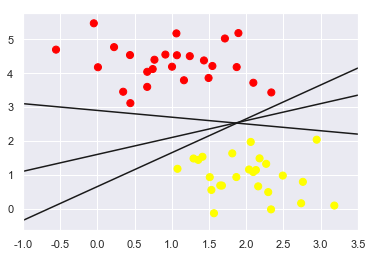

In [6]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

## SVM：假象每一条分割线是有宽度的

(-1, 3.5)

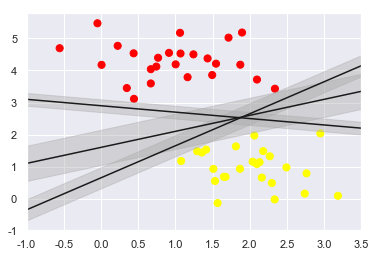

In [7]:
# np.linspace()在指定的间隔内返回均匀的数字
# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
# 在指定的间隔内返回均匀间隔的数字。
# 返回num均匀分布的样本，在[start, stop]。
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    # 通过plt.fill_between()来将间距填充
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

在SVM下，认为最宽距离的线为最优分割线

## 训练SVM
使用线性SVM和比较大的C

In [8]:
from sklearn.svm import SVC # support vector classifier
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### 创建一个显示SVM分割线的函数

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

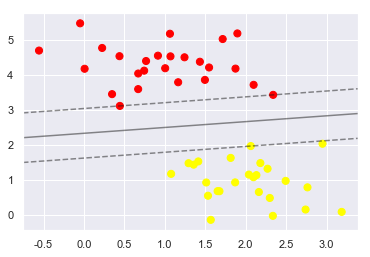

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

In [11]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

发现只有三个支持向量。

### 非支持向量的数据，对分割线没有影响。
只有支持向量对分割线有影响，如果我们添加一些非支持向量的数据，对分割线没有影响。

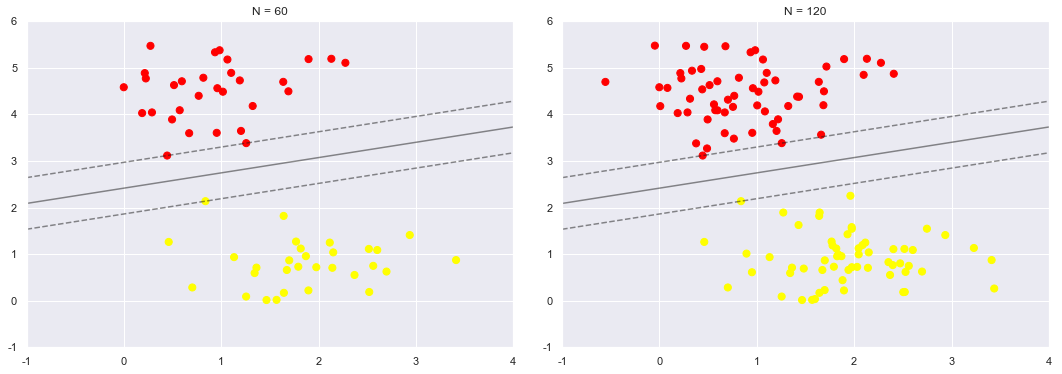

In [12]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

发现分割线还是在中间的位置，不会因为非支持向量数据的添加而改变位置。

## 二、使用SVM进行人脸识别

In [18]:
from sklearn.datasets import fetch_lfw_people
# try:
#     faces = fetch_lfw_people(min_faces_per_person=60)
# except(OSError, NameError):
#     print('OSError')
faces = fetch_lfw_people(min_faces_per_person=60)  # 这里faces就是需要的数据集
print(faces.target_names)
print(faces.images.shape)

['Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder' 'Junichiro Koizumi'
 'Tony Blair']
(914, 62, 47)


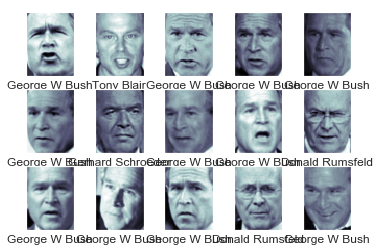

In [19]:
fig, ax = plt.subplots(3, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

每一幅图的尺寸为 [62×47] , 大约 3000 个像素值

我们可以将整个图像展平为一个长度为3000左右的一维向量, 然后使用这个向量做为特征. 通常更有效的方法是通过预处理提取图像最重要的特征. 一个重要的特征提取方法是 **PCA(主成分分析)** , 可以将一副图像转换为一个长度为更短的(这里假定为150)向量.

In [20]:
from sklearn.svm import SVC  # ???????????????????????????
# 从sklearn中导入PCA模块
from sklearn.decomposition import PCA  # ???????????????????????????
from sklearn.pipeline import make_pipeline  # ???????????????????????????
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='linear', class_weight='balanced')

model = make_pipeline(pca, svc)

### 将数据分为训练集和测试集

In [21]:
from sklearn.model_selection import train_test_split     # ???????????????????????????
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

### 调参：通过交叉验证寻找最佳的C（控制间隔的大小）

In [27]:
# from sklearn.model_selection import GridSearchCV   # ?????????????????????????

# # 用一个字典装测试所选的参数
# param_grid = {'svc_C': [1, 5, 10, 50]}
# grid = GridSearchCV(model, param_grid)  # 这样就成了一个模型了？带有多个参数的模型grid？？？

# %time grid.fit(Xtrain, ytrain)  # 用带有多个参数的模型去训练训练数据吗？
# print(grid.best_params_)  # grid.best_params_是效果最好也对应着最好参数的模型吗？

#Error: ## AttributeError: 'GridSearchCV' object has no attribute 'best_params_' ????????????

from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C': [1, 5, 10, 50]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

/Users/jason/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 7.47 s, sys: 251 ms, total: 7.72 s
Wall time: 1.95 s
{'svc__C': 1}


In [28]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

### 使用训练好的SVM做预测

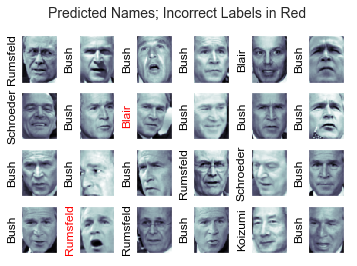

In [30]:
fig, ax = plt.subplots(4, 6)
# ax.flat  # 这个是啥？？？？？？？？？弄清楚
for i, axi in enumerate(ax.flat):   # ？？？？？？？？？？enumerate
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
    
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);
    

### 生成性能报告

In [31]:
from sklearn.metrics import classification_report    # ？？？？？？？？？？？？？？？
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

  Donald Rumsfeld       0.73      0.76      0.75        29
    George W Bush       0.90      0.92      0.91       133
Gerhard Schroeder       0.95      0.83      0.88        23
Junichiro Koizumi       0.91      0.91      0.91        23
       Tony Blair       0.65      0.62      0.63        21

        micro avg       0.86      0.86      0.86       229
        macro avg       0.83      0.81      0.82       229
     weighted avg       0.86      0.86      0.86       229



### 混淆矩阵

Text(89.18, 0.5, 'predicted label')

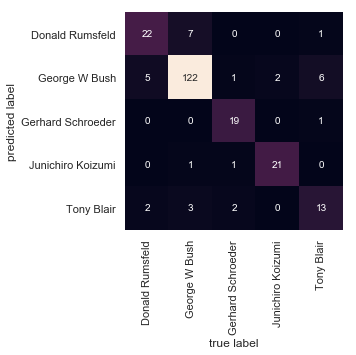

In [32]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,   # ？？？？？？？？？？？
            xticklabels = faces.target_names,
            yticklabels = faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

## SVM总结                                                                                                                                                                                                                                                    
### 优点                                                                                                                                                   
- 模型只需要保存支持向量, 模型占用内存少, 预测快.
- 分类只取决于支持向量, 适合数据的维度高的情况, 例如DNA数据

### 缺点
- 训练的时间复杂度为 $\mathcal{O}[N^3]$ 或者至少 $\mathcal{O}[N^2]$, 当数据量巨大时候不合适使用.
- 需要做调参 $C$ 当数据量大时非常耗时间.



In [2]:
li = [[1,2],[2,2]]
li[0]

[1, 2]

In [3]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [4]:
# Load data
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [5]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


In [8]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Import Support Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=10, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9777777777777777
